In [40]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
from tqdm import tqdm
import pickle


In [41]:
# Load in Graph and Artist Data
with open("./saved_objects/main_graph.pkl", "rb") as f:
    G = pickle.load(f)
with open("./saved_objects/artist_info.pkl", "rb") as f:
    artist_info = pickle.load(f)

# 3. Community Detection and Identification
...

In [42]:
# Detect communities with the Louvain Algorithm
all_communities = nx.community.louvain_communities(G)
print("Number of communties: ", len(all_communities))

Number of communties:  113


In [43]:
# Compute modularity score to assess partitioning
modularity = nx.community.modularity(G, all_communities, weight='weight', resolution=1)
print("Network Modularity: ",modularity) # Quite high, indicates strong community structure

Network Modularity:  0.7807799165878292


Filter the communties via an artist size threshhold to remove less relevent communities. \
Then, create a list of the communties as subgraphs to perform sugraph analysis

In [44]:

# Filter communties by size threshhold, then sort
MIN_COMM_SIZE = 200

# This will be the list of commuties we will reference from here on out
communities = sorted([comm for comm in all_communities if len(comm) >= MIN_COMM_SIZE], key=len, reverse=True)
print("Number of communties (filtered): ", len(communities))

# Create a list of community subgraphs for further analysis
comm_subgraphs = [G.subgraph(comm) for comm in communities]

# Save Objects
with open("./saved_objects/community_subgraphs.pkl", "wb") as f:
    pickle.dump(comm_subgraphs, f)
with open("./saved_objects/community_node_sets.pkl", "wb") as f:
    pickle.dump(communities, f)

Number of communties (filtered):  38


## _Density Measures_

Compute density measures for each community, all indexed the same. Produce and analyze global measures

In [45]:

# List of community density measures by index
comm_sizes = [len(comm) for comm in communities]
edge_densities = [nx.density(comm_sub) for comm_sub in comm_subgraphs]
avg_cluster_coeffs = [np.mean(list(nx.clustering(comm_sub).values())) for comm_sub in comm_subgraphs]
conductances = [nx.algorithms.conductance(G, comm) for comm in communities]

# # Save Objects
# with open("./saved_objects/communities_by_sizes.pkl", "wb") as f:
#     pickle.dump(comm_sizes, f)
# with open("./saved_objects/communities_by_edge_densities.pkl", "wb") as f:
#     pickle.dump(edge_densities, f)
# with open("./saved_objects/communities_by_avg_cluster_coeffs.pkl", "wb") as f:
#     pickle.dump(avg_cluster_coeffs, f)
# with open("./saved_objects/communities_by_conductances.pkl", "wb") as f:
#     pickle.dump(conductances, f)
    

print("Average Conductance: ", np.mean(conductances))
print("Min Conductance: ", min(conductances))
print("Max Conductance: ",max(conductances))
print()
# Very low average conductance shows strong community cohesion
print("Average relative edge density: ", np.mean(edge_densities))
print("Min relative edge density: ", min(edge_densities))
print("Max relative edge density: ",max(edge_densities))
print()

print("Mean of Means Clustering Coefficent: ", np.mean(avg_cluster_coeffs))
print("Min Average Clustering Coefficent: ", min(avg_cluster_coeffs))
print("Max Average Clustering Coefficent: ",max(avg_cluster_coeffs))
print()

Average Conductance:  0.12174139543293157
Min Conductance:  0.015427769985974754
Max Conductance:  0.3126283987915408

Average relative edge densitiy:  0.0035496931098909553
Min relative edge density:  0.00042797367961870344
Max relative edge densitiy:  0.008808460160016154

Mean of Means Clustering Coefficent:  0.11319167912523828
Min Average Clustering Coefficent:  0.020823571364385517
Max Average Clustering Coefficent:  0.20511095233255858



Plot local community density measures and compare to eachother

C:\Users\jesse\AppData\Local\Temp\ipykernel_1700\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_1700\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_1700\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\jesse\AppData\Local\Temp\ipykernel_1700\730407291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


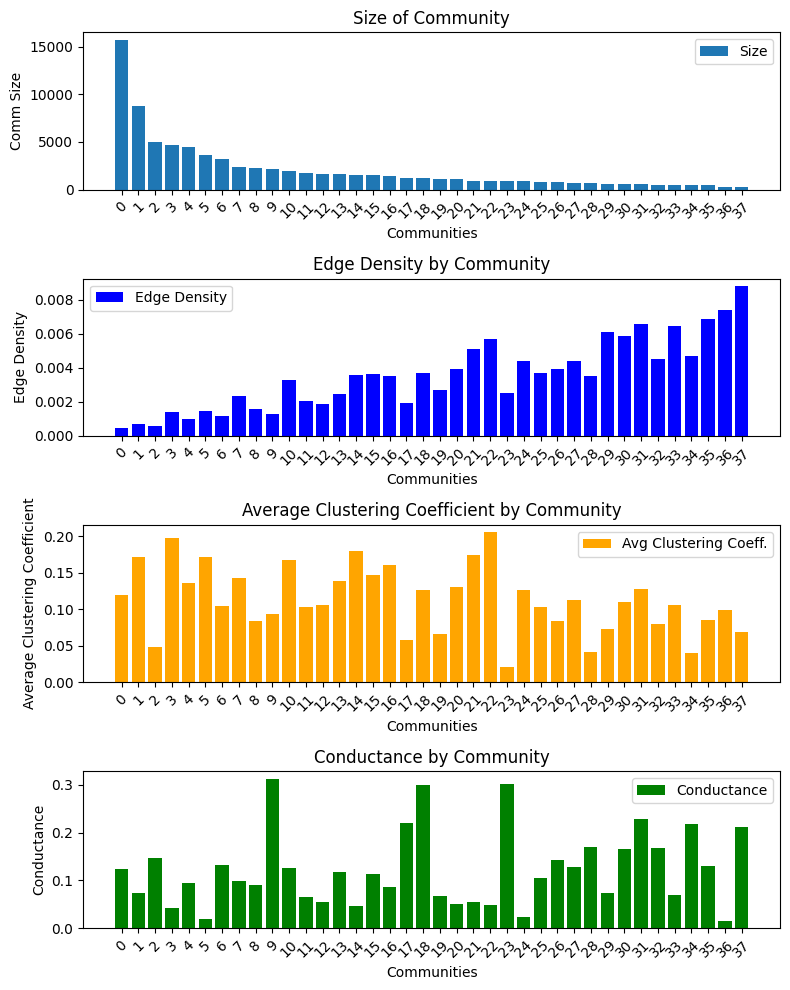

In [46]:
labels = [f"{i}" for i in range(len(edge_densities))]
x = np.arange(len(labels))  # the label locations

fig, axs = plt.subplots(4, 1, figsize=(8, 10))  # Increased figure size

# Plot for Comm Size
axs[0].bar(labels, comm_sizes, label='Size')
axs[0].set_ylabel('Comm Size')
axs[0].set_title('Size of Community')
axs[0].legend()

# Plot for Edge Density
axs[1].bar(labels, edge_densities, color='b', label='Edge Density')
axs[1].set_ylabel('Edge Density')
axs[1].set_title('Edge Density by Community')
axs[1].legend()

# Plot for Average Clustering Coefficient
axs[2].bar(labels, avg_cluster_coeffs, color='orange', label='Avg Clustering Coeff.')
axs[2].set_ylabel('Average Clustering Coefficient')
axs[2].set_title('Average Clustering Coefficient by Community')
axs[2].legend()

# Plot for Conductance
axs[3].bar(labels, conductances, color='g', label='Conductance')
axs[3].set_ylabel('Conductance')
axs[3].set_title('Conductance by Community')
axs[3].legend()

for ax in axs:
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel('Communities')

fig.tight_layout()  # Adjust layout to make sure everything fits without overlap

plt.show()
# Clearly we can see no relation between size and conductance

## _Community Identification and Genre Labal Analysis_

Get top 5 genres per community, to identify. 

In [62]:
from collections import Counter

genres_by_community = []

for comm in communities:
    comm_genres = []
    for node in comm:
        comm_genres.extend(artist_info[node][2])
    genres_by_community.append(comm_genres)

top_five_genres_per_comm = []
# Assuming genres_by_community is already populated with the list of genres per community
for index, genres in enumerate(genres_by_community):
    # Count the frequency of each genre in the community
    genre_counter = Counter(genres)
    # Get the most common 5 genres
    top_five_genres = genre_counter.most_common(5)
    top_five_genres_per_comm.append(list(top_five_genres))
    # Print the top 5 genres for this community
    print(f"Top 5 genres for Community {index + 1}:")
    for genre, count in top_five_genres:
        print(f"{genre} ({count} times)")
    print("\n")  # Add a newline for better readability between communities

# Save
with open("./saved_objects/genres_by_community.pkl", "wb") as f:
    pickle.dump(genres_by_community, f)


Top 5 genres for Community 1:
electro house (457 times)
pop (456 times)
dance pop (421 times)
rap (418 times)
edm (398 times)


Top 5 genres for Community 2:
trap latino (297 times)
latin pop (260 times)
reggaeton (246 times)
reggaeton flow (238 times)
latin hip hop (202 times)


Top 5 genres for Community 3:
classical performance (232 times)
country (141 times)
adult standards (130 times)
classical (116 times)
mellow gold (111 times)


Top 5 genres for Community 4:
funk carioca (342 times)
funk mtg (244 times)
sertanejo pop (170 times)
funk ostentacao (166 times)
brazilian hip hop (144 times)


Top 5 genres for Community 5:
german hip hop (424 times)
german underground rap (193 times)
german pop (188 times)
german trap (182 times)
turkish pop (172 times)


Top 5 genres for Community 6:
filmi (348 times)
desi pop (313 times)
modern bollywood (251 times)
desi hip hop (187 times)
punjabi pop (185 times)


Top 5 genres for Community 7:
swedish hip hop (194 times)
swedish trap pop (178 tim

From this we learn that regionality is a huge factor in community separation, more so than even genre. In addition we see the dominance of hip hop across all communities. 

---

Analyze number of unique genres as compared to size of community. 

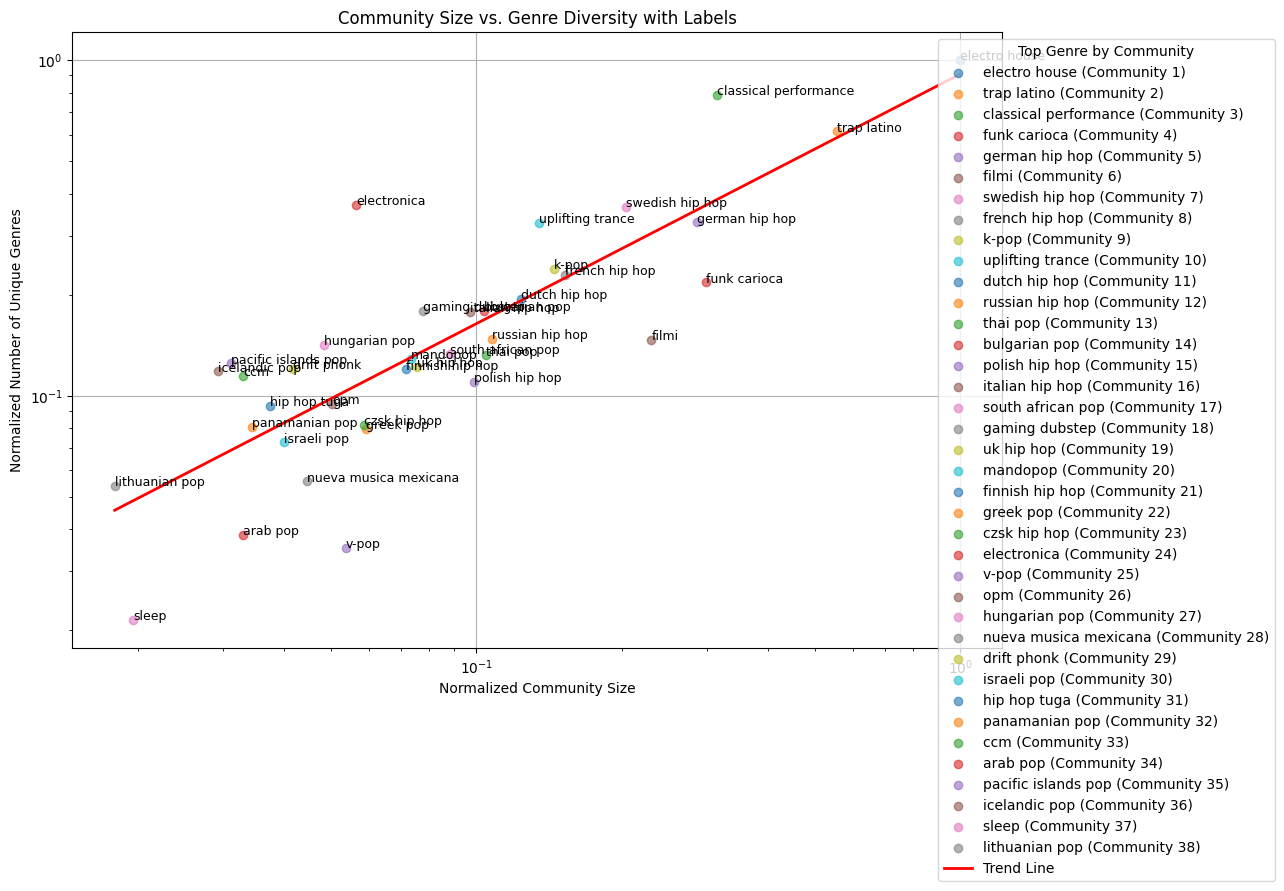

In [61]:
# Assuming genre_counts captures the most frequent genre for each community
top_genres = [max(set(genres), key=genres.count) for genres in genres_by_community]  # Most frequent genre per community

# Example data structure updates
community_sizes = [len(comm) for comm in communities]
genre_counts = [len(set(genres)) for genres in genres_by_community]

# Normalize data for better visualization
normalized_sizes = np.array(community_sizes) / max(community_sizes)
normalized_genre_counts = np.array(genre_counts) / max(genre_counts)

# Create a scatter plot
plt.figure(figsize=(12, 8))
for i in range(len(normalized_sizes)):
    plt.scatter(normalized_sizes[i], normalized_genre_counts[i], alpha=0.6, label=f'{top_genres[i]} (Community {i+1})')
    plt.text(normalized_sizes[i], normalized_genre_counts[i], f'{top_genres[i]}', fontsize=9)

slope, intercept = np.polyfit(np.log(normalized_sizes), np.log(normalized_genre_counts), 1)
line = np.exp(intercept) * normalized_sizes ** slope
plt.plot(normalized_sizes, line, color='red', linewidth=2, label='Trend Line')

# Add titles and labels
plt.title('Community Size vs. Genre Diversity with Labels')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Normalized Community Size')
plt.ylabel('Normalized Number of Unique Genres')
plt.legend(title="Top Genre by Community", loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the plot
plt.grid(True)
plt.show()


Identify the most dense communities

In [67]:

# Print top 5 genres for each of the top 5 communities by each metric
print("Top 5 Genres by Community Size:")
size_indices = np.argsort(comm_sizes)[::-1][:5]  # Get indices of the top 5 by size
for idx in size_indices:
    print(f"\t {comm_sizes[idx]}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Edge Density:")
density_indices = np.argsort(edge_densities)[::-1][:5]  # Get indices of the top 5 by edge density
for idx in density_indices:
    print(f"\t {edge_densities[idx]:.4f}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Clustering Coefficient:")
clustering_indices = np.argsort(avg_cluster_coeffs)[::-1][:5]  # Get indices of the top 5 by clustering coefficient
for idx in clustering_indices:
    print(f"\t {avg_cluster_coeffs[idx]:.2f}: {top_five_genres_per_comm[idx]}")

print("\nBottom 5 Genres by Conductance:")
conductance_indices = np.argsort(conductances)[:5]  # Get indices of the lowest 5 by conductance (better if lower)
for idx in conductance_indices: 
    print(f"\t {conductances[idx]:.2f}: {top_five_genres_per_comm[idx]}")

Top 5 Genres by Community Size:
	 15749: [('electro house', 457), ('pop', 456), ('dance pop', 421), ('rap', 418), ('edm', 398)]
	 8749: [('trap latino', 297), ('latin pop', 260), ('reggaeton', 246), ('reggaeton flow', 238), ('latin hip hop', 202)]
	 4954: [('classical performance', 232), ('country', 141), ('adult standards', 130), ('classical', 116), ('mellow gold', 111)]
	 4690: [('funk carioca', 342), ('funk mtg', 244), ('sertanejo pop', 170), ('funk ostentacao', 166), ('brazilian hip hop', 144)]
	 4496: [('german hip hop', 424), ('german underground rap', 193), ('german pop', 188), ('german trap', 182), ('turkish pop', 172)]

Top 5 Genres by Edge Density:
	 0.0088: [('lithuanian pop', 83), ('lithuanian hip hop', 21), ('lithuanian edm', 16), ('lithuanian trap', 12), ('dark techno', 7)]
	 0.0074: [('sleep', 98), ('environmental', 28), ('lullaby', 21), ('sound', 13), ('meditation', 10)]
	 0.0069: [('icelandic pop', 129), ('classic icelandic pop', 57), ('icelandic hip hop', 41), ('icela

Least dense communities

In [ ]:
# Print top 5 genres for each of the top 5 communities by each metric
print("Top 5 Genres by Community Size:")
size_indices = np.argsort(comm_sizes)[::-1][:5]  # Get indices of the top 5 by size
for idx in size_indices:
    print(f"\t {comm_sizes[idx]}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Edge Density:")
density_indices = np.argsort(edge_densities)[::-1][:5]  # Get indices of the top 5 by edge density
for idx in density_indices:
    print(f"\t {edge_densities[idx]:.4f}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Clustering Coefficient:")
clustering_indices = np.argsort(avg_cluster_coeffs)[::-1][:5]  # Get indices of the top 5 by clustering coefficient
for idx in clustering_indices:
    print(f"\t {avg_cluster_coeffs[idx]:.2f}: {top_five_genres_per_comm[idx]}")

print("\nTop 5 Genres by Conductance:")
conductance_indices = np.argsort(conductances)[:5]  # Get indices of the lowest 5 by conductance (better if lower)
for idx in conductance_indices: 
    print(f"\t {conductances[idx]:.2f}: {top_five_genres_per_comm[idx]}")

## _Analyze Weak Tie Edges_